In [1]:
"""
Version: 2025-09-20
Author: Rubin Dasgupta & Christian Steinmetzger, Petzold group

This notebook runs simulations and generates figures for the manuscript. Common settings are imported from the
respective settings.py file. To explore the effect of varying certain parameters, define new ranges that don't
overwrite these default settings or use context managers for temporary changes.
"""

# -------
# Imports
# -------
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pandas as pd

from r1_rho_equations import two_state_two_noe_cr_matrix
import settings
from utility_functions import cm2inch, dipolar_relaxation

In [2]:
# --------
# Settings
# --------
'''System parameters'''
r1 = settings.r1                        # Same longitudinal relaxation rates for states A and B in 1/s
r2 = settings.r2                        # Same transverse relaxation rates for states A and B in 1/s
delta_r1 = settings.delta_r1            # By default, same R1 for the dipolar-coupled proton
delta_r2 = settings.delta_r2            # By default, same R2 for the dipolar-coupled proton

pB = settings.pB                        # 0.5% population of state B
kex = settings.kex                      # Exchange rate between states A and B in 1/s
delta_omega_B = settings.delta_omega_B  # Chemical shift difference between states A and B in Hz

r_noe = settings.r_noe                  # Distance of dipolar-coupled proton in state A in m
r_noe_es = settings.r_noe_es            # Distance of dipolar-coupled proton in state B in m
tau_c = settings.tau_c                  # Rotational correlation time in s
s2 = settings.s2                        # Order parameter
tau_int = settings.tau_int              # Correlation time of internal motions in s
delta_omega_C = settings.delta_omega_C  # Chemical shift difference between state A and the dipolar-coupled proton in Hz
'''End of system parameters'''

'''Plot settings'''
file_path = settings.file_path          # Path to save plots, make sure it exists first
file_type = settings.file_type          # Output file format
file_res = settings.file_res            # dpi resolution for non-vector graphics
font_size = settings.font_size
'''End of plot settings''';

The following figures show the behavior of R1rho and R2eff when R2 of the dipolar-coupled proton is different from R2 in states A and B. The R2 due to autorelaxation is indicated by a red dotted line on the on-resonance plot. Offsets of the exchanging state and dipolar-coupled proton are indicated by white and orange vertical dashed lines, respectively.

In [3]:
'''On resonance with different R2 for the dipolar proton'''
'''Off resonance with different R2 for the dipolar proton'''
delta_r2_range = np.linspace(0, 20, 2)    # Range of R2 differences to explore
equation = two_state_two_noe_cr_matrix

sl_strength_list = []
sl_offset_list = []
data_collection = {}

# Parameters for on-resonance SL
pt_on = 20
sl_strength_list.append(np.logspace(2, 4, pt_on, base=10))
sl_offset_list.append(np.linspace(0., 0., pt_on))

# Parameters for off-resonance SL
pt_off = 200
offres_sls = [150, 200]
offres_offs = np.linspace(-2000., 2000., pt_off)
for offres_sl in offres_sls:
    sl_strength_list.append(np.linspace(offres_sl, offres_sl, pt_off))
    sl_offset_list.append(offres_offs)

# Collect all input settings
sl_strength_array = np.concatenate(sl_strength_list)
sl_offset_array = np.concatenate(sl_offset_list)
data_collection['sl_strength'] = sl_strength_array
data_collection['sl_offset'] = sl_offset_array
simulated_points = pd.DataFrame(data=data_collection)
simulation_input = {'x_values': (simulated_points['sl_strength'].values,
                                 simulated_points['sl_offset'].values)
                    }

# Create output
points_on_res_list = []
points_off_res_list = []
off_res_curves_list = []
for current_delta_r2 in delta_r2_range:
    params = r1, r2, delta_r1, current_delta_r2, kex, pB, delta_omega_B, delta_omega_C, r_noe, r_noe_es, tau_c, tau_int, s2

    simulated_points['r1_rho'], simulated_points['r2_eff'] = equation(simulation_input['x_values'],
                                                                      *params,
                                                                      result_type='both')
    points_on_res = simulated_points.query('sl_offset == 0')
    points_off_res = simulated_points.query('sl_offset != 0')
    off_res_curves = points_off_res.groupby('sl_strength')
    points_on_res_list.append(points_on_res)
    points_off_res_list.append(points_off_res)
    off_res_curves_list.append(off_res_curves)

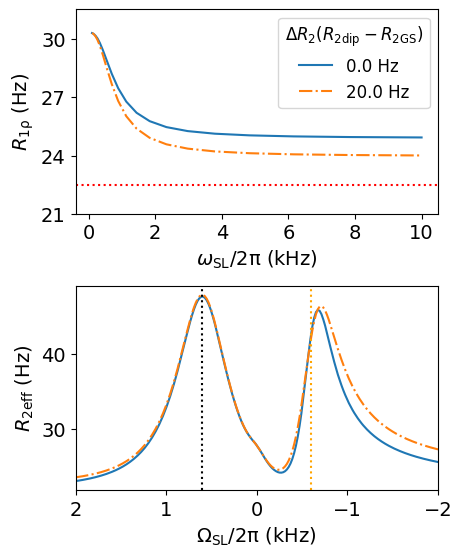

In [4]:
''' Plotting parameters '''
# Only plot off-resonance for the first SL gamma B1 and skip plotting off-resonance R1rho on ax2
dimension_figure = [12, 20]  # in cm [width, height]
fig = plt.figure(figsize=(cm2inch(dimension_figure[0], dimension_figure[1])))
ax1 = fig.add_subplot(3, 1, 1)
# ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 2)

color=["black", "orange"]
alpha = [0.8, 0.6]
line = ["-", "-."]

for i in range(len(delta_r2_range)):
    ax1.plot(1e-3*points_on_res_list[i]['sl_strength'], points_on_res_list[i]['r1_rho'], line[i],
             label=f"{delta_r2_range[i]}" + " Hz")
    for counter, (sl_strength, current_dataset) in enumerate(off_res_curves_list[i]):
        if counter == 0:
            # ax2.plot(1e-3*current_dataset['sl_offset'], current_dataset['r1_rho'], line[i])
            ax3.plot(1e-3*current_dataset['sl_offset'], current_dataset['r2_eff'], line[i])

ax1.tick_params(axis='both',labelsize=14)
ax1.set_ylim(21, 31.5)
ax1.yaxis.set_major_locator(MultipleLocator(3))
ax1.set_xlabel(r"$\omega_{\mathrm {SL}}/\mathrm{2 \pi}$ (kHz)", fontsize = 14)
ax1.set_ylabel(r"$R_{1\mathrm{\rho}}$ (Hz)", fontsize = 14)
ax1.axhline(y=r2, linestyle=":", color="red")

# ax2.tick_params(axis='both',labelsize=14)
# ax2.set_xlim(1e-3*max(offres_offs), 1e-3*min(offres_offs))
# ax2.set_xlabel(r"$\Omega_{\mathrm {SL}}\mathrm{2 \pi$ (kHz)", fontsize = 14)
# ax2.set_ylabel(r"$R_{1\mathrm{\rho}}$ (Hz)", fontsize = 14)
# ax2.axvline(x=1e-3*delta_omega_B, linestyle=":", color="black")
# ax2.axvline(x=1e-3*delta_omega_C, linestyle=":", color="orange")

ax3.tick_params(axis='both',labelsize=14)
ax3.set_xlim(1e-3*max(offres_offs), 1e-3*min(offres_offs))
ax3.set_xlabel(r"$\Omega_{\mathrm {SL}}/\mathrm{2 \pi}$ (kHz)", fontsize = 14)
ax3.set_ylabel(r"$R_{2\mathrm{eff}}$ (Hz)", fontsize = 14)
ax3.axvline(x=1e-3*delta_omega_B, linestyle=":", color="black")
ax3.axvline(x=1e-3*delta_omega_C, linestyle=":", color="orange")

plt.tight_layout()
ax1.legend(title = r"$\Delta R_\mathrm{2} (R_\mathrm{2dip} - R_\mathrm{2GS})$", fontsize = font_size, title_fontsize = font_size)
# plt.savefig(f"{file_path}/Figure_R2dip.{file_type}", dpi=file_res)
plt.show()

The following figures show the effect of having the dipolar-coupled proton at various distances to ground state spin. The distance to the excited state proton is always kept far away. The behavior of the z-magnetization at long and short distances to the dipolar-coupled proton is shown when an off-resonance SL is applied.

In [5]:
'''On resonance for different distances to dipolar proton with GS and ES'''
'''Off resonance for different distances of the dipolar proton wth GS and ES'''
r_noe_range = np.linspace(2.e-10, 4e-10, 100)   # Range of distances to explore
r_noe_es_range = r_noe_range + 40e-10
equation = two_state_two_noe_cr_matrix

sl_strength_list = []
sl_offset_list = []
data_collection = {}

# Parameters for on-resonance SL
pt_on = 20
sl_strength_list.append(np.logspace(2, 4, pt_on, base=10))
sl_offset_list.append(np.linspace(0., 0., pt_on))

# Parameters for off-resonance SL
pt_off = 200
offres_sls = [250]
offres_offs = np.linspace(-2000., 2000., pt_off)
for offres_sl in offres_sls:
    sl_strength_list.append(np.linspace(offres_sl, offres_sl, pt_off))
    sl_offset_list.append(offres_offs)

# Collect all input settings
sl_strength_array = np.concatenate(sl_strength_list)
sl_offset_array = np.concatenate(sl_offset_list)
data_collection['sl_strength'] = sl_strength_array
data_collection['sl_offset'] = sl_offset_array
simulated_points = pd.DataFrame(data=data_collection)
simulation_input = {'x_values': (simulated_points['sl_strength'].values,
                                 simulated_points['sl_offset'].values)
                    }

# Create output
dfs = []
for current_r_noe, current_r_noe_es in zip(r_noe_range, r_noe_es_range):
    params = r1, r2, delta_r1, delta_r2, kex, pB, delta_omega_B, delta_omega_C, current_r_noe, current_r_noe_es, tau_c, tau_int, s2

    simulated_points['r1_rho'], simulated_points['r2_eff'], t_sl, m_final = equation(simulation_input['x_values'],
                                                                                     *params,
                                                                                     result_type='both+mag')
    simulated_points['t_sl'] = list(t_sl)
    simulated_points['m_final'] = list(m_final)
    simulated_points['r_noe'], simulated_points['r_noe_es'] = current_r_noe, current_r_noe_es
    dfs.append(simulated_points.copy())
simulated_points = pd.concat(dfs, ignore_index=True)
points_on_res = simulated_points.query('sl_offset == 0')
points_off_res = simulated_points.query('sl_offset != 0')
off_res_curves = points_off_res.groupby('sl_strength')

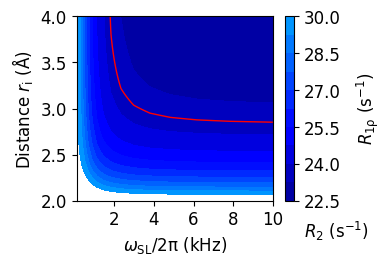

In [6]:
''' Plotting parameters on-resonance contour plot for different distances'''
dimension_figure = [10, 7]  # in cm [width, height]
fig, ax = plt.subplots(figsize=(cm2inch(dimension_figure[0], dimension_figure[1])))
pivot = points_on_res.pivot(index='r_noe', columns='sl_strength', values='r1_rho')
x = np.array(pivot.columns)
y = np.array(pivot.index)
X, Y = np.meshgrid(x, y)
Z = pivot.values
cp = plt.contourf(1e-3*X, 1e10*Y, Z, cmap="jet",
                  levels=np.linspace(22.5, 30, 11), vmin=22, vmax=50
                  )
cp1 = plt.contour(1e-3*X, 1e10*Y, Z, levels=(23.625,), colors=("red",), linewidths=(1,))
cbar = fig.colorbar(cp)
ax.tick_params(axis='both',labelsize=font_size)
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.set_xlabel(r"$\omega_{\mathrm {SL}}/\mathrm{2 \pi}$ (kHz)", fontsize=font_size)
ax.set_ylabel(r"Distance $r_{\mathrm {i}}$ $(\mathrm{\AA})$", fontsize=font_size)
cbar.set_label(r'$R_{1\mathrm{\rho}}$ ($\mathrm{s^{-1}}$)', fontsize=font_size, labelpad=10)
cbar.ax.text(2, -0.2, r'$R_{\mathrm{2}}$ ($\mathrm{s^{-1}}$)', transform=cbar.ax.transAxes, fontsize=font_size)
cbar.ax.tick_params(labelsize=font_size)
plt.tight_layout()
# plt.savefig(f"{file_path}/Figure_on-res_dist_ES-small-GS.{file_type}", dpi = file_res)
plt.show()

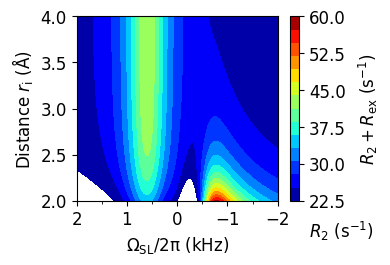

In [7]:
"Plotting routine for off-resonance contour plot with different distances"
# Note that the offset is passed in with a negative sign on the x-axis due to the definition of delta in the simulations
dimension_figure = [10, 7]  # in cm [width, height]
fig, ax = plt.subplots(figsize=(cm2inch(dimension_figure[0], dimension_figure[1])))
pivot = points_off_res.pivot(index='r_noe', columns='sl_offset', values='r2_eff')
x = np.array(pivot.columns)
y = np.array(pivot.index)
X, Y = np.meshgrid(x, y)
Z = pivot.values
cp = plt.contourf(1e-3*X, 1e10*Y, Z, cmap="jet",
                  levels=np.linspace(22.5, 60, 15), vmin=22.5, vmax=60
                  )
cbar = fig.colorbar(cp)
ax.tick_params(axis='both',labelsize=font_size)
ax.xaxis.set_major_locator(MultipleLocator(1.0))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.set_xlabel(r"$\Omega_{\mathrm {SL}}/\mathrm{2 \pi}$ (kHz)", fontsize = font_size)
ax.set_ylabel(r"Distance $r_{\mathrm {i}}$ $(\mathrm{\AA})$", fontsize = font_size)
cbar.set_label(r'$R_{\mathrm{2}} + R_{\mathrm{ex}}$ ($\mathrm{s^{-1}}$)', fontsize=font_size, labelpad=8)
cbar.ax.text(2, -0.2, r'$R_{\mathrm{2}}$ ($\mathrm{s^{-1}}$)', transform=cbar.ax.transAxes, fontsize=font_size)
cbar.ax.tick_params(labelsize=font_size)
# cbar.ax.yaxis.set_major_locator(MultipleLocator(3.5))
cbar.ax.set_yticks(np.linspace(22.5, 60, 6))
plt.xlim(2.0, -2.0)
plt.tight_layout()
# plt.savefig(f"{file_path}/Figure_off-res_dist.{file_type}", dpi = file_res)
plt.show()

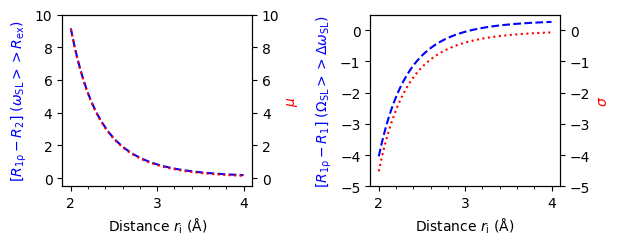

In [8]:
"""Plotting the limit of the R1ρ at high spin lock and far off resonance in presence of the dipolar proton"""
dimension_figure = [16, 6.5]
data_on = points_on_res[points_on_res['sl_strength'] == points_on_res['sl_strength'].max()]
data_off = points_off_res[points_off_res['sl_offset'] == points_off_res['sl_offset'].max()]
mu, sigma, r1_dip, r2_dip = dipolar_relaxation(r_noe_range, tau_c, tau_int, s2)
fig = plt.figure(figsize=(cm2inch(dimension_figure[0], dimension_figure[1])))
fig.tight_layout()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, sharex=ax1)
ax1_twin = ax1.twinx()
ax2_twin = ax2.twinx()
ax1.xaxis.set_minor_locator(MultipleLocator(0.2))
ax1.plot(1e10*data_on['r_noe'], data_on['r1_rho']-r2, '--', color="blue")
ax1_twin.plot(1e10*r_noe_range, mu, ':', color="red")
ax1.set_ylabel(r"$[R_\mathrm{1\rho} - R_\mathrm{2}]$ $(\omega_\mathrm{SL} >> R_\mathrm{ex})$", color="blue")
ax1_twin.set_ylabel(r"$\mu$", color="red")
ax2.plot(1e10*data_off['r_noe'], data_off['r1_rho']-r1, "--", color="blue")
ax2_twin.plot(1e10*r_noe_range, sigma, ":", color="red")
ax2.set_ylabel(r"$[R_\mathrm{1\rho} - R_\mathrm{1}]$ $(\Omega_\mathrm{SL} >> \Delta\omega_\mathrm{SL})$", color="blue")
ax1.set_ylim(-0.5, 10)
ax1_twin.set_ylim(-0.5, 10)
ax2.set_ylim(-5, 0.5)
ax2_twin.set_ylim(-5, 0.5)
ax2_twin.set_ylabel(r"$\sigma$", color="red")
ax2.set_xlabel(r"Distance $r_\mathrm{i}$ $(\mathrm{\AA}$)")
ax1.set_xlabel(r"Distance $r_\mathrm{i}$ $(\mathrm{\AA}$)")
plt.tight_layout()
# plt.savefig(f"{file_path}/Figure_mu_sigma.{file_type}", dpi=file_res)
plt.show()

/var/folders/vn/_9r00jys4jjdqg2b9j6n9z0c0000gn/T/ipykernel_95381/2723445172.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


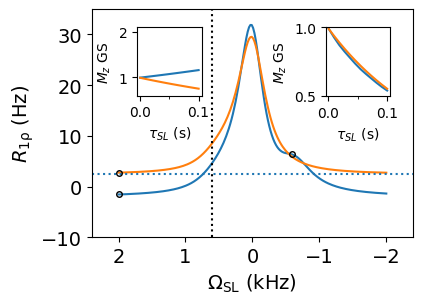

In [9]:
"Plotting to show exponential rise at extreme offsets with low distance compared to normal distance"
dimension_figure = [11, 8]  # in cm [width, height]
data_long = points_off_res[points_off_res['r_noe'] == points_off_res['r_noe'].max()]
data_short = points_off_res[points_off_res['r_noe'] == points_off_res['r_noe'].min()]
off_large_idx = -1
off_small_idx = 70

fig, ax = plt.subplots(figsize=(cm2inch(dimension_figure[0], dimension_figure[1])))
ax.plot(1e-3*data_short['sl_offset'], data_short['r1_rho'])
ax.plot(1e-3*data_long['sl_offset'], data_long['r1_rho'])
ax.axhline(y=r1, linestyle=':')
ax.set_xlim(2.4, -2.4)
ax.set_ylim(-10, 35)
ax.set_ylabel(r"$R_{1\mathrm{\rho}}$ (Hz)", fontsize=14)
ax.set_xlabel(r"$\Omega_\mathrm{SL}$ (kHz)", fontsize=14)
ax.plot(1e-3*data_short['sl_offset'].iloc[off_small_idx], data_short['r1_rho'].iloc[off_small_idx], "o", markersize=4, fillstyle="none", color="black")
ax.plot(1e-3*data_short['sl_offset'].iloc[off_large_idx], data_short['r1_rho'].iloc[off_large_idx], "o", markersize=4, fillstyle="none", color="black")
ax.plot(1e-3*data_long['sl_offset'].iloc[off_large_idx], data_long['r1_rho'].iloc[off_large_idx], "o", markersize=4, fillstyle="none", color="black")
ax.tick_params(axis="both", labelsize = 14)
ax.axvline(1e-3*delta_omega_B, linestyle=":", color="black")
axins_1 = inset_axes(ax, width="50%", height="60%", bbox_to_anchor=(0.55, 0.45, 0.4, 0.5), bbox_transform=ax.transAxes)
axins_2 = inset_axes(ax, width="50%", height="60%", bbox_to_anchor=(0.12, 0.59, 0.4, 0.5), bbox_transform=ax.transAxes, loc=3)
axins_1.plot(data_short['t_sl'].iloc[off_small_idx], data_short['m_final'].iloc[off_small_idx][:, 2])
axins_1.plot(data_long['t_sl'].iloc[off_small_idx], data_long['m_final'].iloc[off_small_idx][:, 2])
axins_1.set_ylim(0.5, 1)
axins_1.set_ylabel(r"$M_{z}$ GS")
axins_1.set_xlabel(r"$\tau_{SL}$ (s)")
axins_1.xaxis.set_minor_locator(MultipleLocator(0.05))
axins_1.yaxis.set_major_locator(MultipleLocator(0.5))
axins_2.plot(data_short['t_sl'].iloc[off_large_idx], data_short['m_final'].iloc[off_large_idx][:, 2])
axins_2.plot(data_long['t_sl'].iloc[off_large_idx], data_long['m_final'].iloc[off_large_idx][:, 2])
axins_2.set_ylabel(r"$M_{z}$ GS")
axins_2.set_xlabel(r"$\tau_{SL}$ (s)")
axins_2.set_ylim(0.6, 2.1)
axins_2.xaxis.set_minor_locator(MultipleLocator(0.05))
fig.tight_layout()
# plt.savefig(f"{file_path}/Figure_S1b.{file_type}", dpi=file_res)
plt.show()

For this set of figures, a far distance of 10 Å is used as a baseline for minimal dipolar contribution, which is then subtracted from the relaxation rates to reveal the magnitude of the dipolar contribution at closer distances. The behavior of the z-magnetization during the SL is shown for the different distances to the dipolar-coupled proton.

In [10]:
'''On resonance for different distances to dipolar proton with GS and ES'''
'''Off resonance for different distances of the dipolar proton wth GS and ES'''
r_noe_range = np.array([2.5e-10, 3.0e-10, 5.0e-10, 10.0e-10])   # Range of distances to explore
r_noe_es_range = r_noe_range + 40e-10
equation = two_state_two_noe_cr_matrix

sl_strength_list = []
sl_offset_list = []
data_collection = {}

# Parameters for on-resonance SL
pt_on = 20
sl_strength_list.append(np.logspace(2, 4, pt_on, base=10))
sl_offset_list.append(np.linspace(0., 0., pt_on))

# Parameters for off-resonance SL
pt_off = 200
offres_sls = [250]
offres_offs = np.linspace(-2000., 2000., pt_off)
for offres_sl in offres_sls:
    sl_strength_list.append(np.linspace(offres_sl, offres_sl, pt_off))
    sl_offset_list.append(offres_offs)

# Collect all input settings
sl_strength_array = np.concatenate(sl_strength_list)
sl_offset_array = np.concatenate(sl_offset_list)
data_collection['sl_strength'] = sl_strength_array
data_collection['sl_offset'] = sl_offset_array
simulated_points = pd.DataFrame(data=data_collection)
simulation_input = {'x_values': (simulated_points['sl_strength'].values,
                                 simulated_points['sl_offset'].values)
                    }

# Create output
dfs = []
for current_r_noe, current_r_noe_es in zip(r_noe_range, r_noe_es_range):
    params = r1, r2, delta_r1, delta_r2, kex, pB, delta_omega_B, delta_omega_C, current_r_noe, current_r_noe_es, tau_c, tau_int, s2

    simulated_points['r1_rho'], simulated_points['r2_eff'], t_sl, m_final = equation(simulation_input['x_values'],
                                                                                     *params,
                                                                                     result_type='both+mag')
    simulated_points['t_sl'] = list(t_sl)
    simulated_points['m_final'] = list(m_final)
    simulated_points['r_noe'], simulated_points['r_noe_es'] = current_r_noe, current_r_noe_es
    dfs.append(simulated_points.copy())
simulated_points = pd.concat(dfs, ignore_index=True)
points_on_res = simulated_points.query('sl_offset == 0')
points_off_res = simulated_points.query('sl_offset != 0')
off_res_curves = points_off_res.groupby('sl_strength')

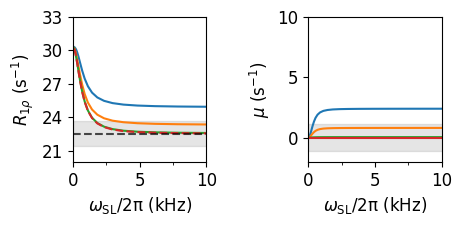

In [11]:
"Plotting routine for comparative on-resonance with different distances (r_noe_range = np.array([2.5e-10, 3.0e-10, 5.0e-10, 10.0e-10]))"
dimension_figure = [12, 6]  # in cm [width, height]
fig = plt.figure(figsize=(cm2inch(dimension_figure[0], dimension_figure[1])))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122, sharex=ax)
y = np.linspace(1, 32)
x = np.linspace(0, 16)

linestyles = ['-', '-', '-', '--']
for (current_r_noe, df), ls in zip(points_on_res.groupby('r_noe'), linestyles):
    dipolar_contri = df['r1_rho'] - points_on_res[points_on_res['r_noe'] == r_noe_range.max()]['r1_rho'].values
    ax.plot(1e-3*df['sl_strength'], df['r1_rho'], linestyle=ls)
    ax1.plot(1e-3*df['sl_strength'], dipolar_contri)

ax.axhline(y=r2*1.05, color='black', linestyle='-', alpha=0.0)
ax.axhline(y=r2*0.95, color='black', linestyle='-', alpha=0.0)
ax.axhline(y=r2, color='black', linestyle='--', alpha=0.7)
ax.fill_between(x, r2*1.05, r2*0.95, color="grey", alpha=0.2)
ax1.fill_between(x, +r2*0.05, -r2*0.05, color="grey", alpha=0.2)
ax.set_xlim(0, 10)
ax.set_ylim(20, 33)
ax.tick_params(axis='both', labelsize=font_size)
ax1.tick_params(axis='both', labelsize=font_size)
ax.yaxis.set_major_locator(MultipleLocator(3))
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(2.5))
ax1.set_ylim(-2, 10)
ax.set_ylabel(r'$R_{\mathrm{1}\rho}$ ($\mathrm{s^{-1}}$)', fontsize = font_size)
ax.set_xlabel(r"$\omega_{\mathrm {SL}}/\mathrm{2 \pi}$ (kHz)", fontsize = font_size)
ax1.set_ylabel(r"$\mu$ ($\mathrm{s^{-1}}$)", fontsize = font_size)
ax1.set_xlabel(r"$\omega_{\mathrm {SL}}/\mathrm{2 \pi}$ (kHz)", fontsize = font_size)
plt.tight_layout()
# plt.savefig(f'{file_path}/Figure_2c.{file_type}', dpi=file_res)
plt.show()

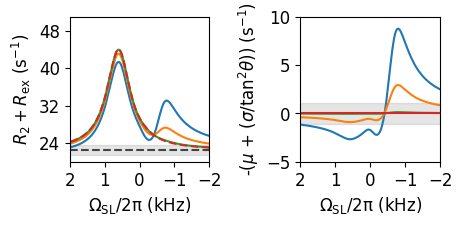

In [12]:
""" Plotting off-resonance r2_eff individual plot at 4 distances """
dimension_figure = [12, 6]  # in cm [width, height]
fig = plt.figure(figsize=(cm2inch(dimension_figure[0], dimension_figure[1])))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122, sharex=ax)
y = np.linspace(1, 32)
x = np.linspace(-16, 16)

linestyles = ['-', '-', '-', '--']
for (current_r_noe, df), ls in zip(points_off_res.groupby('r_noe'), linestyles):
    dipolar_contri = df['r2_eff'] - points_off_res[points_off_res['r_noe'] == r_noe_range.max()]['r2_eff'].values
    ax.plot(1e-3*df['sl_offset'], df['r2_eff'], linestyle=ls)
    ax1.plot(1e-3*df['sl_offset'], dipolar_contri)

ax.axhline(y=22.5+22.5*0.05, color='black', linestyle='-', alpha=0.0)
ax.axhline(y=22.5-22.5*0.05, color='black', linestyle='-', alpha=0.0)
ax.axhline(y=22.5, color='black', linestyle='--', alpha=0.7)
ax.fill_between(x, 22.5+22.5*0.05, 22.5-22.5*0.05, color="grey", alpha=0.2)
ax1.fill_between(x, +22.5*0.05, -22.5*0.05, color="grey", alpha=0.2)
ax.set_xlim(2.0, -2.0)
ax.set_ylim(20, 51)
ax.tick_params(axis='both', labelsize=font_size)
ax1.tick_params(axis='both', labelsize=font_size)
ax.yaxis.set_major_locator(MultipleLocator(8))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(2.5))
ax1.set_ylim(-5, 10)
ax.set_ylabel(r'$R_{\mathrm{2}} + R_{\mathrm{ex}}$ ($\mathrm{s^{-1}}$)', fontsize = font_size)
ax.set_xlabel(r"$\Omega_{\mathrm {SL}}/\mathrm{2 \pi}$ (kHz)", fontsize = font_size)
ax1.set_ylabel(r"-($\mu$ + ($\sigma/\mathrm{tan^2}\theta$)) ($\mathrm{s^{-1}}$)", fontsize = font_size)
ax1.set_xlabel(r"$\Omega_{\mathrm {SL}}/\mathrm{2 \pi}$ (kHz)", fontsize = font_size)
plt.tight_layout()
# plt.savefig(f'{file_path}/Figure_1d.{file_type}', dpi=file_res)
plt.show()

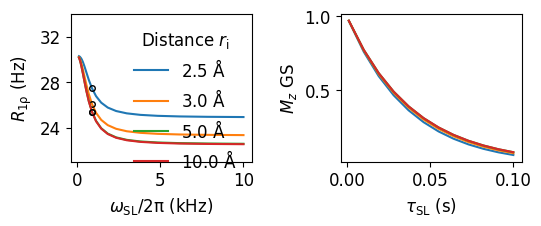

In [13]:
"Plotting of the on-resonance for extreme distances (low and high) to show the behaviour of Mz(GS) vs tsl for on-resonance"
dimension_figure = [14, 6]
on_idx = 9

fig = plt.figure(figsize=(cm2inch(dimension_figure[0], dimension_figure[1])))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
# ax1ins = inset_axes(ax1, width="60%", height="90%",
#                    bbox_to_anchor=(.5, .25, .6, .5),
#                    bbox_transform=ax1.transAxes, loc=3)
for (current_r_noe, df), ls in zip(points_on_res.groupby('r_noe'), linestyles):
    ax1.plot(1e-3*df['sl_strength'], df['r1_rho'],  label=f"{1e10*current_r_noe}" + r" $\mathrm{\AA}$")
    ax1.plot(1e-3*df['sl_strength'].iloc[on_idx], df['r1_rho'].iloc[on_idx], 'o', color="black", fillstyle="none", markersize=4)
    ax2.plot(df['t_sl'].iloc[on_idx], df['m_final'].iloc[on_idx][:, 2])

ax1.legend(title = r"Distance $r_\mathrm{i}$", fontsize = font_size, title_fontsize = font_size, frameon=False)
ax1.set_ylim(21, 34)
ax1.yaxis.set_major_locator(MultipleLocator(4))
ax1.set_xlabel(r"$\omega_{\mathrm {SL}}/\mathrm{2\pi}$ (kHz)", fontsize = font_size)
ax1.set_ylabel(r"$R_{1\mathrm{\rho}}$ (Hz)", fontsize = font_size)
ax1.tick_params(axis='both',labelsize=font_size)
ax2.set_ylabel(r"$M_{z}$ GS", fontsize=font_size)
ax2.set_xlabel(r"$\tau_\mathrm{SL}$ (s)", fontsize=font_size)
ax2.tick_params(axis='both',labelsize=font_size)
plt.tight_layout()
# plt.savefig(f"{file_path}/Figure_S1a_var.{file_type}", dpi=file_res)
plt.show()

The following figures show the effect of moving the chemical shift of the dipolar-coupled proton closer to the ground state resonance. The distance to the dipolar-coupled proton is kept constant at 2.5/40 Å to spins in state A/B.

In [14]:
"Simulation with different Δωdip to show that the contribution reduces when it is close to 0. The distance is kept at 2.5 ang"
delta_omega_C_range = np.array([0, 500, 700, 1000, 1500])   # Range of offsets to explore
# delta_omega_C_range = np.linspace(0, 1500, 100)
equation = two_state_two_noe_cr_matrix

sl_strength_list = []
sl_offset_list = []
data_collection = {}

# Parameters for on-resonance SL
pt_on = 20
sl_strength_list.append(np.logspace(2, 4, pt_on, base=10))
sl_offset_list.append(np.linspace(0., 0., pt_on))

# Parameters for off-resonance SL
pt_off
offres_sls = [250]
offres_offs = np.linspace(-5000., 5000., pt_off)
for offres_sl in offres_sls:
    sl_strength_list.append(np.linspace(offres_sl, offres_sl, pt_off))
    sl_offset_list.append(offres_offs)

# Collect all input settings
sl_strength_array = np.concatenate(sl_strength_list)
sl_offset_array = np.concatenate(sl_offset_list)
data_collection['sl_strength'] = sl_strength_array
data_collection['sl_offset'] = sl_offset_array
simulated_points = pd.DataFrame(data=data_collection)
simulation_input = {'x_values': (simulated_points['sl_strength'].values,
                                 simulated_points['sl_offset'].values)
                    }

# Create output
dfs = []
for current_delta_omega_C in delta_omega_C_range:
    params = r1, r2, delta_r1, delta_r2, kex, pB, delta_omega_B, current_delta_omega_C, r_noe, r_noe_es, tau_c, tau_int, s2

    simulated_points['r1_rho'], simulated_points['r2_eff'] = equation(simulation_input['x_values'],
                                                                      *params,
                                                                      result_type='both')
    simulated_points['delta_omega_C'] = current_delta_omega_C
    dfs.append(simulated_points.copy())
simulated_points = pd.concat(dfs, ignore_index=True)
points_on_res = simulated_points.query('sl_offset == 0')
points_off_res = simulated_points.query('sl_offset != 0')
off_res_curves = points_off_res.groupby('sl_strength')

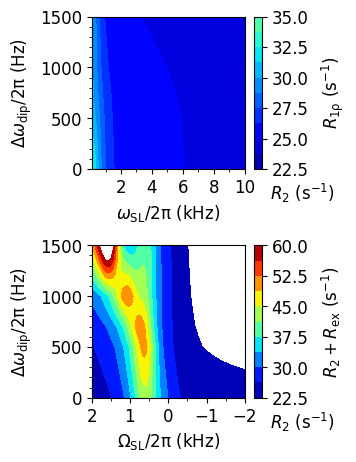

In [15]:
dimension_figure = [9, 12]
fig = plt.figure(figsize=(cm2inch(dimension_figure[0], dimension_figure[1])))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharey=ax1)

"On resonance plotting"
pivot = points_on_res.pivot(index='delta_omega_C', columns='sl_strength', values='r1_rho')
x = np.array(pivot.columns)
y = np.array(pivot.index)
X, Y = np.meshgrid(x, y)
Z = pivot.values
on = ax1.contourf(1e-3*X, Y, Z, cmap='jet',
                  levels = np.linspace(22.5, 35, 11), vmin=22, vmax=50
                  )
cbar_on = fig.colorbar(on, ax=ax1)
cbar_on.ax.tick_params(labelsize=font_size)
# cbar_on.ax.set_title(r"$R_{1\mathrm{\rho}}$ (Hz)", size=font_size, pad=12)
cbar_on.set_label(r'$R_{1\mathrm{\rho}}$ ($\mathrm{s^{-1}}$)', fontsize=font_size, labelpad=8)
cbar_on.ax.text(2, -0.2, r'$R_{\mathrm{2}}$ ($\mathrm{s^{-1}}$)', transform=cbar_on.ax.transAxes, fontsize=font_size)

"off resonance plotting"
pivot1 = points_off_res.pivot(index='delta_omega_C', columns='sl_offset', values='r2_eff')
x1 = np.array(pivot1.columns)
y1 = np.array(pivot1.index)
X1, Y1 = np.meshgrid(x1, y1)
Z1 = pivot1.values
off = ax2.contourf(1e-3*X1, Y1, Z1, cmap="jet",
                   levels = np.linspace(22.5, 60, 11), vmin=22.5, vmax=60
                   )
cbar_off = fig.colorbar(off, ax=ax2)
cbar_off.ax.tick_params(labelsize=font_size)
# cbar_off.ax.set_title(r"$R_{2\mathrm{eff}}$ (Hz)", size=font_size, pad=12)
cbar_off.set_label(r'$R_{\mathrm{2}} + R_{\mathrm{ex}}$ ($\mathrm{s^{-1}}$)', fontsize=font_size, labelpad=8)
cbar_off.ax.text(2, -0.2, r'$R_{\mathrm{2}}$ ($\mathrm{s^{-1}}$)', transform=cbar_off.ax.transAxes, fontsize=font_size)

ax1.tick_params(axis="both", labelsize=font_size)
ax1.yaxis.set_major_locator(MultipleLocator(500))
ax1.yaxis.set_minor_locator(MultipleLocator(100))
ax1.xaxis.set_major_locator(MultipleLocator(2))
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.set_xlabel(r"$\omega_\mathrm{SL}/\mathrm{2\pi}$ (kHz)", fontsize=font_size)
ax1.set_ylabel(r"$\Delta\omega_\mathrm{dip}/\mathrm{2\pi}$ (Hz)", fontsize=font_size)

ax2.set_xlabel(r"$\Omega_\mathrm{SL}/\mathrm{2\pi}$ (kHz)", fontsize=font_size)
ax2.set_ylabel(r"$\Delta\omega_\mathrm{dip}/\mathrm{2\pi}$ (Hz)", fontsize=font_size)
ax2.xaxis.set_major_locator(MultipleLocator(1))
ax2.xaxis.set_minor_locator(MultipleLocator(0.5))
ax2.set_xlim(2, -2)
ax2.tick_params(axis="both", labelsize=font_size)
plt.tight_layout()
# plt.savefig(f"{file_path}/Figure_off_resonance_dip_position_oppposite_ES.{file_type}", dpi=file_res)
plt.show()

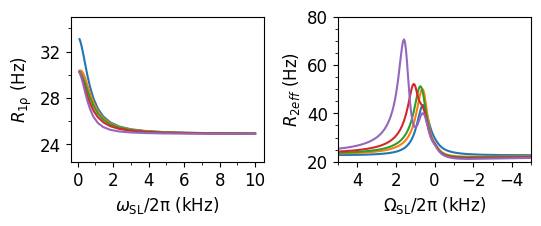

In [16]:
""" Plotting routine to show the r1rho at different Δωdip positions """
dimension_figure = [14, 6]
fig, ax = plt.subplots(1, 2, figsize=(cm2inch(dimension_figure[0], dimension_figure[1])))
ax1 = ax[0]
ax2 = ax[1]
for (current_delta_omega_C, df_on), (_, df_off) in zip(points_on_res.groupby('delta_omega_C'), points_off_res.groupby('delta_omega_C')):
    ax1.plot(1e-3*df_on['sl_strength'], df_on['r1_rho'])
    ax2.plot(1e-3*df_off['sl_offset'], df_off['r2_eff'])
ax1.tick_params(axis="both", labelsize=font_size)
ax1.set_ylim(22.5, 35)
ax1.yaxis.set_major_locator(MultipleLocator(4))
ax1.yaxis.set_minor_locator(MultipleLocator(2))
ax1.xaxis.set_major_locator(MultipleLocator(2))
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.set_xlabel(r"$\omega_\mathrm{SL}/\mathrm{2\pi}$ (kHz)", fontsize=font_size)
ax1.set_ylabel(r"$R_{1\mathrm{\rho}}$ (Hz)", fontsize=font_size)

ax2.tick_params(axis="both", labelsize=font_size)
ax2.xaxis.set_major_locator(MultipleLocator(2))
ax2.xaxis.set_minor_locator(MultipleLocator(1.0))
ax2.set_xlabel(r"$\Omega_\mathrm{SL}/\mathrm{2\pi}$ (kHz)", fontsize=font_size)
ax2.set_ylabel(r"$R_{2eff}$ (Hz)", fontsize=font_size)
ax2.yaxis.set_major_locator(MultipleLocator(20))
ax2.yaxis.set_minor_locator(MultipleLocator(5))
ax2.set_ylim(20, 80)
ax2.set_xlim(5, -5)
plt.tight_layout()
# plt.savefig(f"{file_path}/Figure_S2b.{file_type}", dpi=file_res)
plt.show()

In [17]:
"Simulation of ωSL dependent position of the Δωdip at distance 2.5 ang"
equation = two_state_two_noe_cr_matrix

sl_strength_list = []
sl_offset_list = []
data_collection = {}

# Parameters for on-resonance SL
pt_on = 20
sl_strength_list.append(np.logspace(2, 4, pt_on, base=10))
sl_offset_list.append(np.linspace(0., 0., pt_on))

# Parameters for off-resonance SL
pt_off = 200
offres_sls = [150, 250, 350, 450, 550]
offres_offs = np.linspace(-4000., 4000., pt_off)
for offres_sl in offres_sls:
    sl_strength_list.append(np.linspace(offres_sl, offres_sl, pt_off))
    sl_offset_list.append(offres_offs)

# Collect all input settings
sl_strength_array = np.concatenate(sl_strength_list)
sl_offset_array = np.concatenate(sl_offset_list)
data_collection['sl_strength'] = sl_strength_array
data_collection['sl_offset'] = sl_offset_array
simulated_points = pd.DataFrame(data=data_collection)
simulation_input = {'x_values': (simulated_points['sl_strength'].values,
                                 simulated_points['sl_offset'].values)
                    }

# Create output
# dfs = []
# for current_delta_omega_C in delta_omega_C_range:
params = r1, r2, delta_r1, delta_r2, kex, pB, delta_omega_B, delta_omega_C, r_noe, r_noe_es, tau_c, tau_int, s2

simulated_points['r1_rho'], simulated_points['r2_eff'] = equation(simulation_input['x_values'],
                                                                  *params,
                                                                  result_type='both')
    # simulated_points['delta_omega_C'] = current_delta_omega_C
    # dfs.append(simulated_points.copy())
# simulated_points = pd.concat(dfs, ignore_index=True)
points_on_res = simulated_points.query('sl_offset == 0')
points_off_res = simulated_points.query('sl_offset != 0')
off_res_curves = points_off_res.groupby('sl_strength')

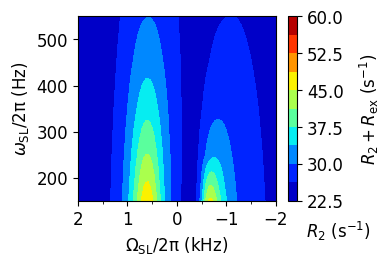

In [18]:
dimension_figure = [10, 7]
fig = plt.figure(figsize=(cm2inch(dimension_figure[0], dimension_figure[1])))
ax2 = fig.add_subplot(1, 1, 1)
ax2.set_xlim(2, -2)

pivot = points_off_res.pivot(index='sl_strength', columns='sl_offset', values='r2_eff')
x = np.array(pivot.columns)
y = np.array(pivot.index)
X, Y = np.meshgrid(x, y)
Z = pivot.values

off = ax2.contourf(1e-3*X, Y, Z, cmap="jet",
                   levels=np.linspace(22.5, 60, 11), vmin=22, vmax=60)
cbar_r2eff = fig.colorbar(off)
cbar_r2eff.ax.tick_params(labelsize=font_size)
cbar_r2eff.set_label(r'$R_{\mathrm{2}} + R_{\mathrm{ex}}$ ($\mathrm{s^{-1}}$)', fontsize=font_size, labelpad=10)
cbar_r2eff.ax.text(2., -0.2, r'$R_{\mathrm{2}}$ ($\mathrm{s^{-1}}$)', transform=cbar_r2eff.ax.transAxes, fontsize=font_size)

ax2.set_xlabel(r"$\Omega_\mathrm{SL}/\mathrm{2\pi}$ (kHz)", fontsize=font_size)
ax2.xaxis.set_major_locator(MultipleLocator(1))
ax2.xaxis.set_minor_locator(MultipleLocator(0.5))
ax2.tick_params(axis="both", labelsize=font_size)
ax2.set_ylabel(r"$\omega_\mathrm{SL}/\mathrm{2\pi}$ (Hz)", fontsize=font_size)
plt.tight_layout()
# plt.savefig(f'{file_path}/Figure_omegaSL_dep_scenario_1.{file_type}', dpi=file_res)
plt.show()

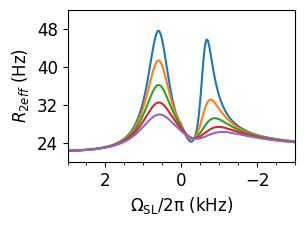

In [19]:
""" Plotting routine to show the r1rho and r2eff at different omegaSL positions of the dipolar proton """
dimension_figure = [8, 6]
fig, ax = plt.subplots(figsize=(cm2inch(dimension_figure[0], dimension_figure[1])))

for current_sl_strength, df_off in off_res_curves:
    ax.plot(1e-3*df_off['sl_offset'], df_off['r2_eff'], label=f"{1e-3*current_sl_strength:.1f}" + r" $\mathrm{kHz}$")
ax.set_ylim(20, 52)
ax.set_xlim(3, -3)
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(8))
ax.set_xlabel(r"$\Omega_\mathrm{SL}/\mathrm{2\pi}$ (kHz)", fontsize=font_size)
ax.set_ylabel(r"$R_{1\mathrm{\rho}}$ (Hz)", fontsize=font_size)
ax.tick_params(axis='both', labelsize=font_size)
ax.set_xlabel(r"$\Omega_\mathrm{SL}/\mathrm{2\pi}$ (kHz)", fontsize=font_size)
ax.set_ylabel(r"$R_{\mathrm{2}eff}$ (Hz)", fontsize=font_size)
plt.tight_layout()
# plt.savefig(f'{file_path}/Figure_S1c.{file_type}', dpi=file_res)
plt.show()